# Brats Notebook MIScnn unimodal
This Jupyter notebook will show you how to use the MIScnn Pipeline for image Segmentation. MIScnn is a Medical Image Segmentation with Convolutional Neural Networks and Deep Learning. In our example we will use the Brats MICCAI Brain tumor dataset 2020. In this Notebook we only use the t2-MRI-scans

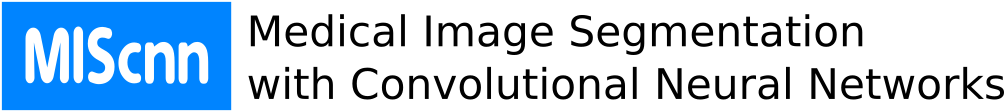
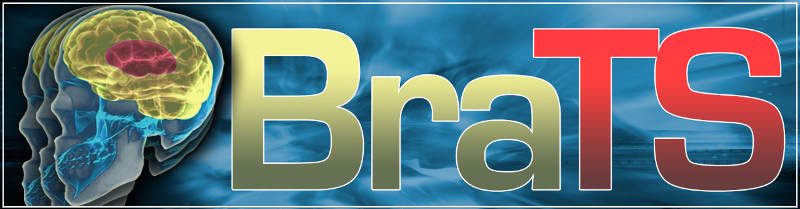

## MIScnn Pipline
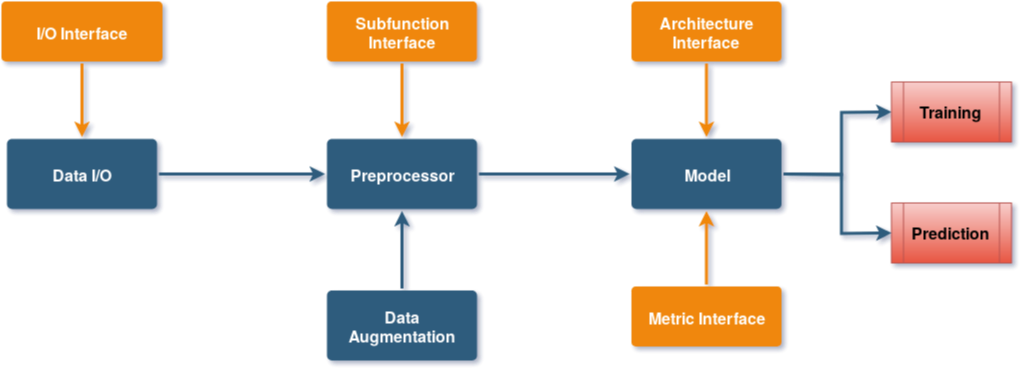

This notebook shows step by step how to implement the MIScnn pipline on the Brats dataset. 
In this example we will do the following steps:

    1. Dataset Prepreation
    2. Data Exploration
    3. MIScnn Pipeline Setup
    4. Training
    5. Prediction
    6. Evaluation

    

# Tensorflow Configurations (optional)
By using the RAM growth option your programm will use a dynamic space of RAM instead of allocating RAM without using it.

In [1]:
import tensorflow as tf

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Dataset Prepreation
The Brats samples ar in NII format. To handle with this format a Data I/O class with an Nifti interface is used.
## Set Filestrucure

### Load samples from orignial Datastructure

In [2]:
# Library import
from miscnn.data_loading.interfaces.nifti_io \
     import NIFTI_interface
from miscnn.data_loading.data_io import Data_IO
import shutil

# Initialize the NIfTI I/O interface and configure the images as one channel (grayscale) and three segmentation classes (background, enhancing, edema, necrotic and non-enhancing)
interface = NIFTI_interface(pattern="BraTS20_Training_[0-9]*", 
                            channels=1, classes=5)

# Specify the Brats data directory
path_dataset = "./data/MICCAI_BraTS2020_TrainingData/"
path_filestructure = "./data/filestructure/"
# Create the Data I/O object 
data_io = Data_IO(interface, path_dataset)
sample_list = data_io.get_indiceslist()
sample_list.sort()
print(sample_list)

['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005', 'BraTS20_Training_006', 'BraTS20_Training_007', 'BraTS20_Training_008', 'BraTS20_Training_009', 'BraTS20_Training_010', 'BraTS20_Training_011', 'BraTS20_Training_012', 'BraTS20_Training_013', 'BraTS20_Training_014', 'BraTS20_Training_015', 'BraTS20_Training_016', 'BraTS20_Training_017', 'BraTS20_Training_018', 'BraTS20_Training_019', 'BraTS20_Training_020', 'BraTS20_Training_021', 'BraTS20_Training_022', 'BraTS20_Training_023', 'BraTS20_Training_024', 'BraTS20_Training_025', 'BraTS20_Training_026', 'BraTS20_Training_027', 'BraTS20_Training_028', 'BraTS20_Training_029', 'BraTS20_Training_030', 'BraTS20_Training_031', 'BraTS20_Training_032', 'BraTS20_Training_033', 'BraTS20_Training_034', 'BraTS20_Training_035', 'BraTS20_Training_036', 'BraTS20_Training_037', 'BraTS20_Training_038', 'BraTS20_Training_039', 'BraTS20_Training_040', 'BraTS20_Training_041', 'BraTS20_Traini

### Set Filestructure

In [3]:
# Initialize file structure
if not os.path.exists(path_filestructure): os.mkdir(path_filestructure)

i=1
for s in sample_list:
    #Copy t2
    #SourceFolder
    path_ds_sample = os.path.join(path_dataset, s) 
    #DestinationFolder
    path_fs_sample = os.path.join(path_filestructure, "sample" + f"{i:03}")
    i = i+1 
    #Create new Destination Folder if not eixsts
    if not os.path.exists(path_fs_sample): os.mkdir(path_fs_sample)
        
    #copy t2
    path_ds_sample_t2 = os.path.join(path_ds_sample, s + '_t2.nii.gz')
    path_fs_sample_t2 = os.path.join(path_fs_sample , 'imaging.nii.gz')
    shutil.copy(path_ds_sample_t2, path_fs_sample_t2)
    
    #copy seg
    path_ds_sample_seg = os.path.join(path_ds_sample, s + "_seg.nii.gz")
    path_fs_sample_seg = os.path.join(path_fs_sample, "segmentation.nii.gz")
    shutil.copy(path_ds_sample_seg, path_fs_sample_seg)
    


# Data Exploration
## Display MRI picture and segmentation example

In [4]:
from miscnn.data_loading.interfaces import NIFTI_interface
from miscnn import Data_IO

path_data = "./data/filestructure/"

#-----------------------------------------------------#
#                   Data Exploration                  #
#-----------------------------------------------------#
# Initialize Data IO Interface for NIfTI data
interface = NIFTI_interface(pattern="sample[0-9]*", 
                            channels=1, classes=5)

# Create Data IO object to load and write samples in the file structure
data_io = Data_IO(interface, path_data, delete_batchDir=True)

# Access all available samples in our file structure
sample_list = data_io.get_indiceslist()
sample_list.sort()

/usr/local/lib/python3.6/dist-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


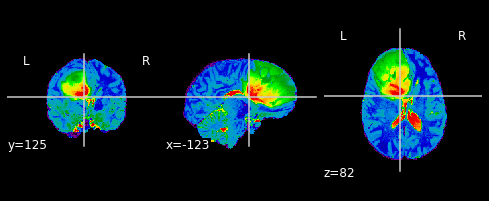

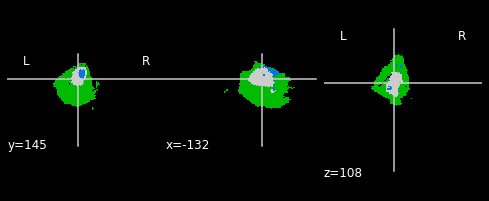

In [5]:
from nilearn.plotting import plot_epi, show
data_path = "./data/filestructure/sample071"
file_name = os.path.join(data_path, 'imaging.nii.gz')
plot_epi(file_name)
file_name = os.path.join(data_path, 'segmentation.nii.gz')
plot_epi(file_name)

peritumoral edema (green),
necrotic and non-enhancing tumor core (grey),
enhancing tumor(blue)

In [6]:
from miscnn.data_loading.interfaces import NIFTI_interface
from miscnn import Data_IO
from tqdm import tqdm
import os
import numpy as np
import pandas as pd

#-----------------------------------------------------#
#                    Configurations                   #
#-----------------------------------------------------#
# Data directory
path_data = "./data/filestructure/"

#-----------------------------------------------------#
#                   Data Exploration                  #
#-----------------------------------------------------#
# Initialize Data IO Interface for NIfTI data
interface = NIFTI_interface(pattern="sample[0-9]*", 
                            channels=1, classes=5)

# Create Data IO object to load and write samples in the file structure
data_io = Data_IO(interface, path_data, delete_batchDir=True)

# Access all available samples in our file structure
sample_list = data_io.get_indiceslist()
sample_list.sort()

# Print out the sample list
print("Sample list:", sample_list)

# Now let's load each sample and obtain collect diverse information from them
sample_data = {}
for index in tqdm(sample_list):
    # Sample loading
    sample = data_io.sample_loader(index, load_seg=True)
    # Create an empty list for the current asmple in our data dictionary
    sample_data[index] = []
    # Store the volume shape
    sample_data[index].append(sample.img_data.shape)
    # Identify minimum and maximum volume intensity
    sample_data[index].append(sample.img_data.min())
    sample_data[index].append(sample.img_data.max())
    # Store voxel spacing
    #sample_data[index].append(sample.details['spacing'])
    # Identify and store class distribution
    unique_data, unique_counts = np.unique(sample.seg_data, return_counts=True)
    class_freq = unique_counts / np.sum(unique_counts)
    class_freq = np.around(class_freq, decimals=6)
    sample_data[index].append(tuple(class_freq))

# Transform collected data into a pandas dataframe
df = pd.DataFrame.from_dict(sample_data, orient="index",
                            columns=["vol_shape", "vol_minimum",
                                     "vol_maximum",
                                     "class_frequency"])

# Print out the dataframe to console
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)

# Calculate mean and median shape sizes
shape_list = np.array(df["vol_shape"].tolist())
for i, a in enumerate(["X", "Y", "Z"]):
    print(a + "-Axes Mean:", np.mean(shape_list[:,i]))
    print(a + "-Axes Median:", np.median(shape_list[:,i]))

# Calculate average class frequency
df_classes = pd.DataFrame(df["class_frequency"].tolist(),
                          columns=["background", "enhancing tumor",
                                   "peritumoral edema", "necrotic and non-enhancing tumor core"])
print(df_classes.mean(axis=0))

  0%|          | 0/369 [00:00<?, ?it/s]

Sample list: ['sample001', 'sample002', 'sample003', 'sample004', 'sample005', 'sample006', 'sample007', 'sample008', 'sample009', 'sample010', 'sample011', 'sample012', 'sample013', 'sample014', 'sample015', 'sample016', 'sample017', 'sample018', 'sample019', 'sample020', 'sample021', 'sample022', 'sample023', 'sample024', 'sample025', 'sample026', 'sample027', 'sample028', 'sample029', 'sample030', 'sample031', 'sample032', 'sample033', 'sample034', 'sample035', 'sample036', 'sample037', 'sample038', 'sample039', 'sample040', 'sample041', 'sample042', 'sample043', 'sample044', 'sample045', 'sample046', 'sample047', 'sample048', 'sample049', 'sample050', 'sample051', 'sample052', 'sample053', 'sample054', 'sample055', 'sample056', 'sample057', 'sample058', 'sample059', 'sample060', 'sample061', 'sample062', 'sample063', 'sample064', 'sample065', 'sample066', 'sample067', 'sample068', 'sample069', 'sample070', 'sample071', 'sample072', 'sample073', 'sample074', 'sample075', 'sample076'

100%|██████████| 369/369 [02:25<00:00,  2.53it/s]

                    vol_shape  vol_minimum   vol_maximum  \
sample001  (240, 240, 155, 1)     0.000000    376.000000   
sample002  (240, 240, 155, 1)     0.000000    690.000000   
sample003  (240, 240, 155, 1)     0.000000    385.000000   
sample004  (240, 240, 155, 1)     0.000000    495.000000   
sample005  (240, 240, 155, 1)     0.000000    497.000000   
sample006  (240, 240, 155, 1)     0.000000    502.000000   
sample007  (240, 240, 155, 1)     0.000000    495.000000   
sample008  (240, 240, 155, 1)     0.000000    522.000000   
sample009  (240, 240, 155, 1)     0.000000    565.000000   
sample010  (240, 240, 155, 1)     0.000000    598.000000   
sample011  (240, 240, 155, 1)     0.000000   2041.000000   
sample012  (240, 240, 155, 1)     0.000000   2522.000000   
sample013  (240, 240, 155, 1)     0.000000    477.000000   
sample014  (240, 240, 155, 1)     0.000000    552.000000   
sample015  (240, 240, 155, 1)     0.000000    584.000000   
sample016  (240, 240, 155, 1)     0.0000

# MIScnn Pipeline Setup

In [7]:
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [8]:
# Import some libraries
from miscnn import Data_IO, Preprocessor, Neural_Network
from miscnn.data_loading.interfaces import Image_interface
from miscnn.neural_network.metrics import tversky_crossentropy, dice_soft, \
                                          dice_crossentropy, tversky_loss
from miscnn.processing.subfunctions import Resize, Normalization
# Library import
from miscnn.data_loading.interfaces.nifti_io \
     import NIFTI_interface
from miscnn.data_loading.data_io import Data_IO

# Initialize the NIfTI I/O interface and configure the images as one channel (grayscale) and three segmentation classes (background, kidney, tumor)
interface = NIFTI_interface(pattern="sample[0-9]*", 
                            channels=1, classes=5)

data_path = "./data/filestructure/"
data_io = Data_IO(interface, data_path, delete_batchDir=True)

# Obtain the sample list
sample_list = data_io.get_indiceslist()
sample_list.sort()

# Library imports
from miscnn.processing.subfunctions.normalization import Normalization
from miscnn.processing.subfunctions.clipping import Clipping
from miscnn.processing.subfunctions.resampling import Resampling

# Create a pixel value normalization Subfunction through Z-Score 
sf_normalize = Normalization(mode='z-score')

# Create a resampling Subfunction to voxel spacing 3.22 x 1.62 x 1.62

sf_resample = Resampling((3.22, 1.62, 1.62))

# Assemble Subfunction classes into a list
# Be aware that the Subfunctions will be exectued according to the list order!
subfunctions = [sf_normalize, sf_resample]

# Initialize Preprocessor
pp = Preprocessor(data_io, batch_size=2, subfunctions=subfunctions, prepare_subfunctions=True, 
                  prepare_batches=False, analysis="patchwise-crop", patch_shape=(80, 160, 160),
                  use_multiprocessing=True)

# Adjust the patch overlap for predictions
pp.patchwise_overlap = (40, 80, 80)

 # Create the Neural Network model
model = Neural_Network(preprocessor=pp, loss=tversky_loss, metrics=[dice_soft, dice_crossentropy],
                       batch_queue_size=3, workers=5, learninig_rate=0.0001)

In [9]:
# Define Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
cb_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=20, verbose=1, mode='min', min_delta=0.0001, cooldown=1,    
                          min_lr=0.00001)
from tensorflow.keras.callbacks import EarlyStopping
cb_es = EarlyStopping(monitor='loss', min_delta=0, patience=150, verbose=1, mode='min')

# Training

## Train without Cross Validation

In [10]:
#model.train(sample_list[:350], epochs=10, iterations=5, callbacks=[cb_lr, cb_es])

## Cross Validation

In [11]:
# Library import
from miscnn.evaluation.cross_validation import cross_validation
# Run cross-validation function
cross_validation(sample_list[:350], model, k_fold=3, epochs=400, iterations=None,
                 evaluation_path="evaluation", draw_figures=True, callbacks=[cb_lr, cb_es])
model.dump("./model")

Epoch 1/400
117/117 [==============================] - 188s 2s/step - loss: 4.1382 - dice_soft: 0.1731 - dice_crossentropy: 1.0702 - val_loss: 4.3276 - val_dice_soft: 0.1345 - val_dice_crossentropy: 1.0961

Epoch 00001: val_loss improved from inf to 4.32764, saving model to evaluation/fold_0/model.hdf5
Epoch 2/400
117/117 [==============================] - 167s 1s/step - loss: 3.9673 - dice_soft: 0.2066 - dice_crossentropy: 0.8451 - val_loss: 4.2005 - val_dice_soft: 0.1594 - val_dice_crossentropy: 0.8770

Epoch 00002: val_loss improved from 4.32764 to 4.20047, saving model to evaluation/fold_0/model.hdf5
Epoch 3/400
117/117 [==============================] - 168s 1s/step - loss: 3.8518 - dice_soft: 0.2310 - dice_crossentropy: 0.8124 - val_loss: 3.9508 - val_dice_soft: 0.2101 - val_dice_crossentropy: 0.8409

Epoch 00003: val_loss improved from 4.20047 to 3.95078, saving model to evaluation/fold_0/model.hdf5
Epoch 4/400
117/117 [==============================] - 168s 1s/step - loss: 3.74

# Prediction

In [12]:
model.predict(sample_list[351:369])

# Evaluation

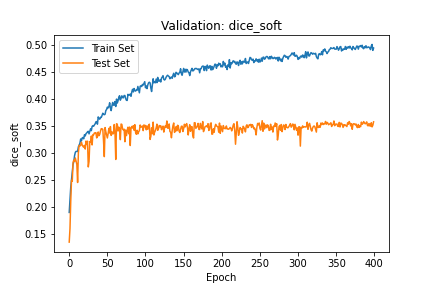

In [13]:
from IPython.display import Image
Image(filename = "evaluation/fold_0/validation.dice_soft.png")

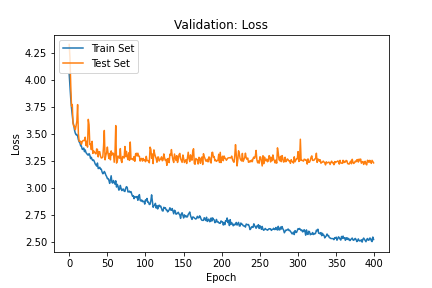

In [14]:
Image(filename = "evaluation/fold_0/validation.loss.png")

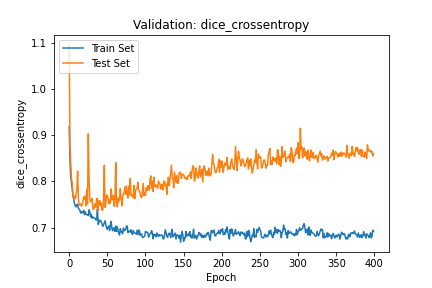

In [15]:
Image(filename = "evaluation/fold_0/validation.dice_crossentropy.png")

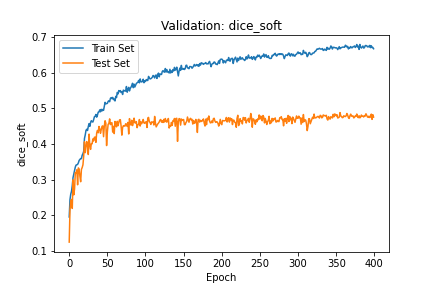

In [16]:
Image(filename = "evaluation/fold_1/validation.dice_soft.png")

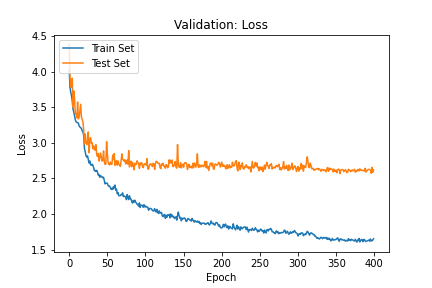

In [17]:
Image(filename = "evaluation/fold_1/validation.loss.png")

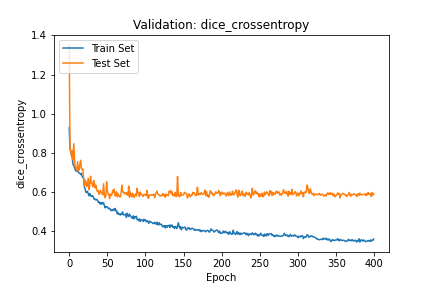

In [18]:
Image(filename = "evaluation/fold_1/validation.dice_crossentropy.png")

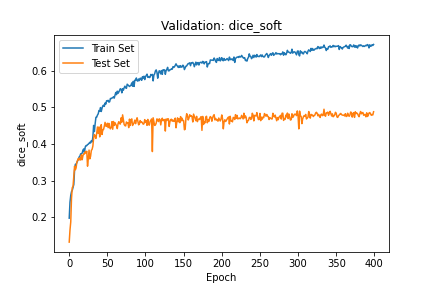

In [19]:
Image(filename = "evaluation/fold_2/validation.dice_soft.png")

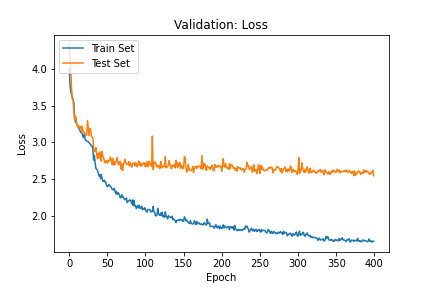

In [20]:
Image(filename = "evaluation/fold_2/validation.loss.png")

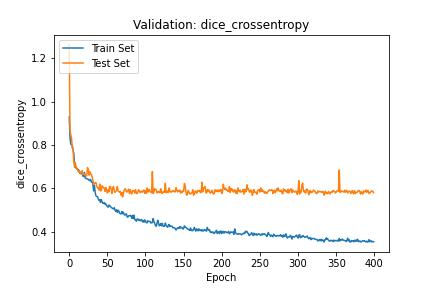

In [21]:
Image(filename = "evaluation/fold_2/validation.dice_crossentropy.png")

In [22]:
from miscnn import Data_IO, Preprocessor, Neural_Network
from miscnn.data_loading.interfaces import NIFTI_interface
from miscnn.processing.subfunctions import Resampling, Normalization

sf_normalize = Normalization(mode='z-score')
sf_resample = Resampling((3.22, 1.62, 1.62)) #3.22 hinten oder vorne?
subfunctions = [sf_normalize, sf_resample]

path_data = "./data/filestructure/"
interface = NIFTI_interface(pattern="sample[0-9]*", 
                            channels=1, classes=5)
data_io = Data_IO(interface, path_data, delete_batchDir=True)
sample_list = data_io.get_indiceslist()
sample_list.sort()
pp = Preprocessor(data_io, batch_size=2, subfunctions=subfunctions, prepare_subfunctions=True, 
                  prepare_batches=False, analysis="patchwise-crop", patch_shape=(80, 160, 160),
                  use_multiprocessing=True)

model = Neural_Network(preprocessor=pp)
model.load('./model')

In [23]:
model.predict(sample_list[351:369])

/usr/local/lib/python3.6/dist-packages/nilearn/plotting/displays.py:667: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


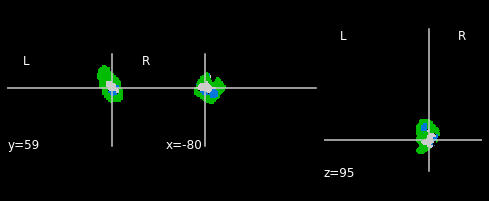

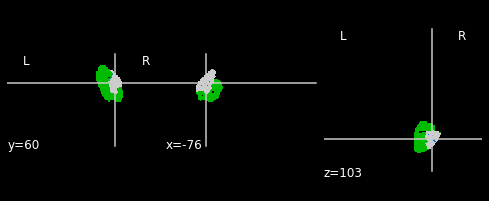

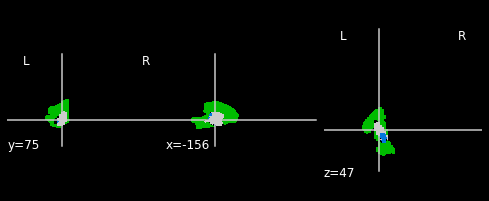

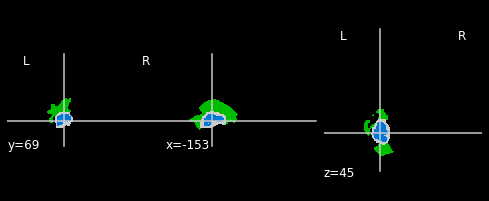

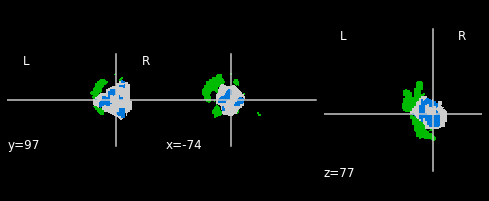

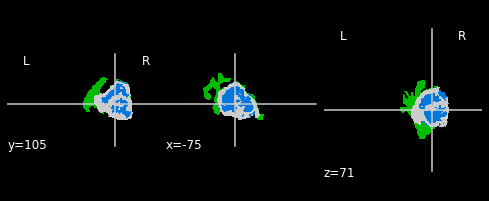

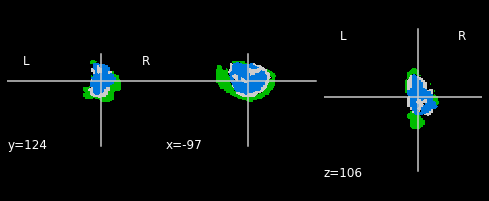

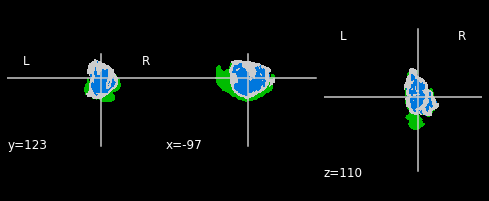

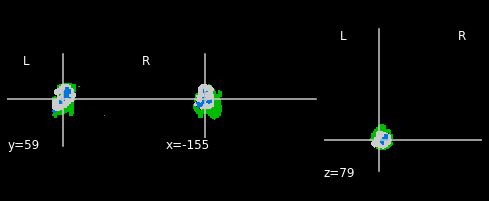

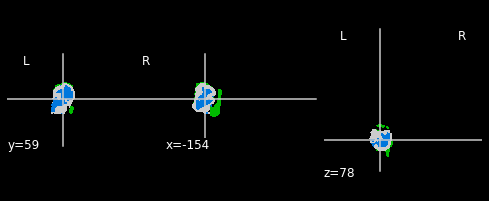

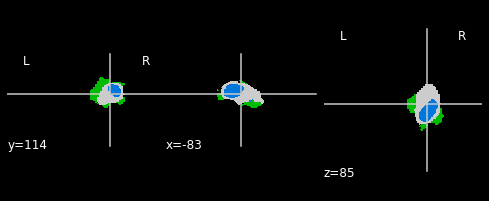

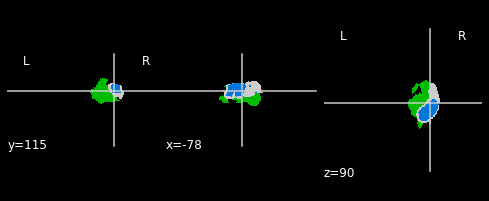

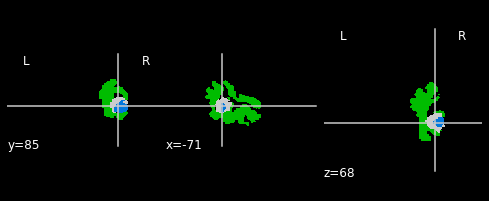

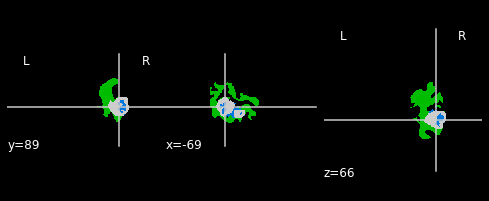

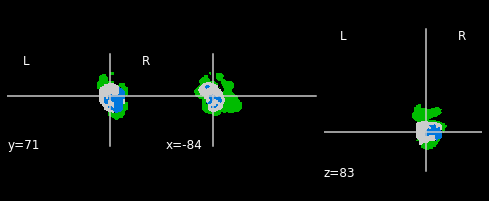

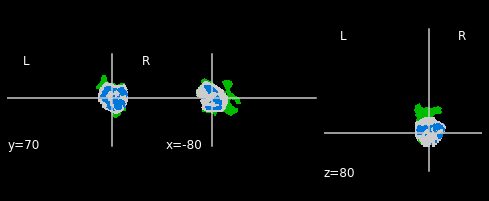

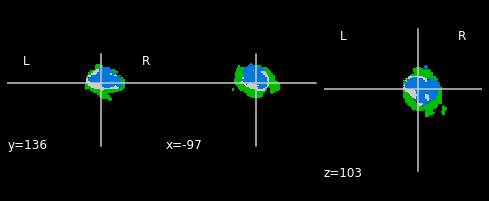

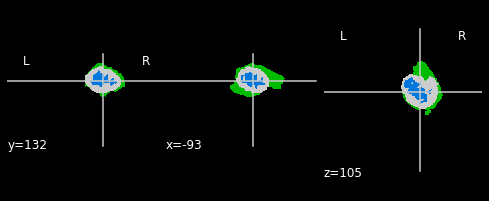

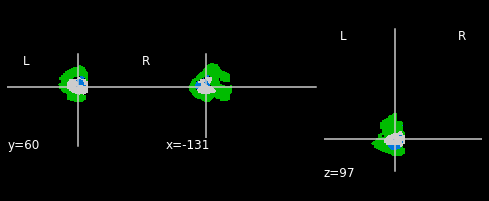

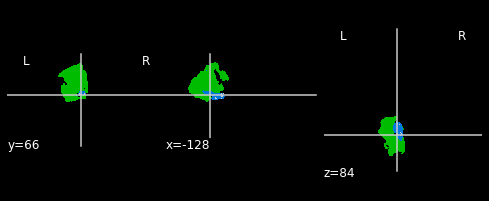

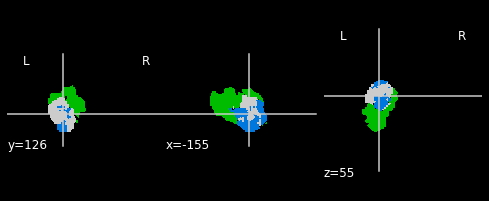

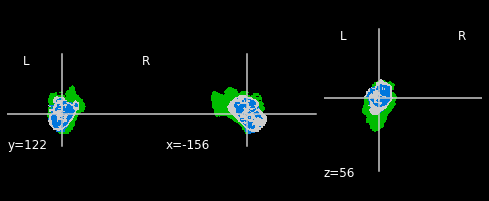

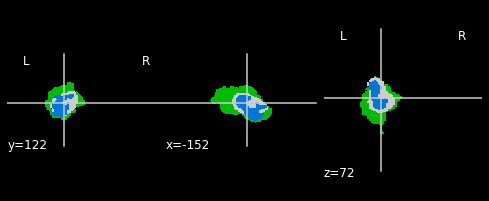

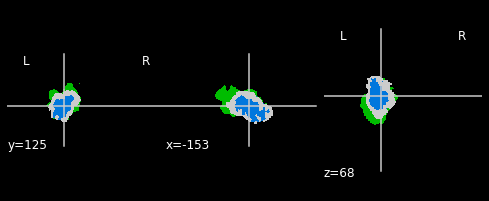

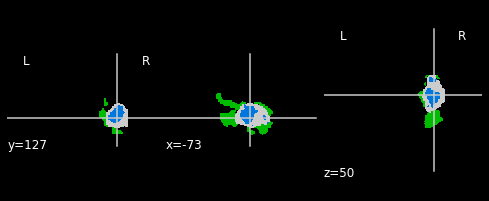

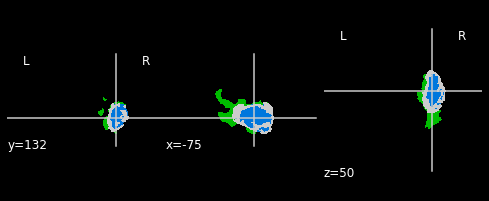

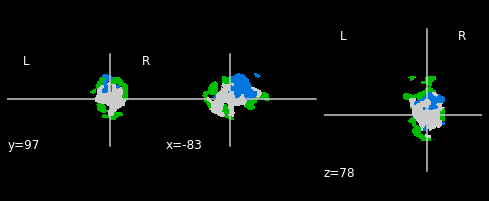

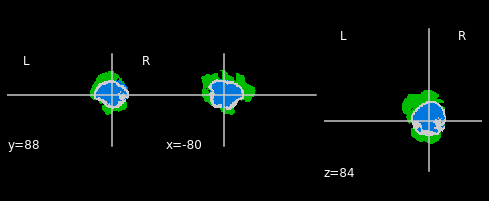

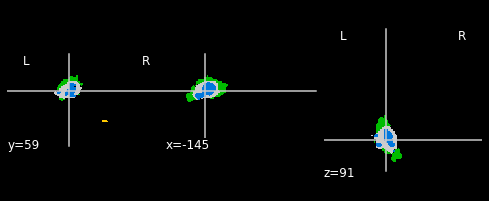

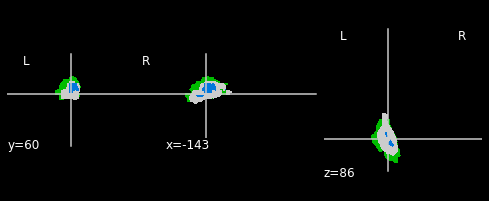

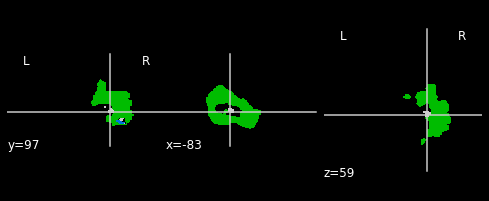

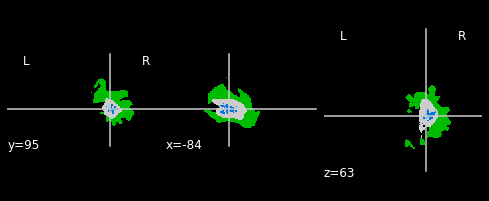

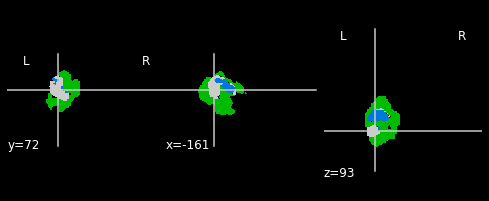

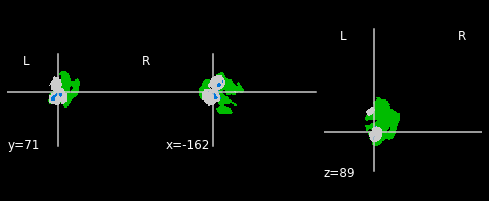

In [24]:
from nilearn.plotting import plot_epi, show
import os
for i in range (352, 369):
    pred_path = "./predictions/sample" + str(i) + ".nii.gz"
    plot_epi(pred_path)
    seg_path = "./data/filestructure/sample" + str(i)+ "/segmentation.nii.gz"
    plot_epi(seg_path)

In [25]:
import numpy as np
from miscnn.data_loading.interfaces.nifti_io \
     import NIFTI_interface
from miscnn.data_loading.data_io import Data_IO
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd


interface = NIFTI_interface(pattern="sample[0-9]*", 
                            channels=1, classes=5)

data_path = "./data/filestructure/"
data_io = Data_IO(interface, data_path, delete_batchDir=True)

sample_data = {}
index=0

for i in range (352, 369):
    sample_data[index] = []
    
    pred = interface.load_prediction("./predictions/sample" + str(i), "./")
    seg = interface.load_segmentation("sample" + str(i))
    pred = pred.ravel()
    seg = seg.ravel()
    print("sample" + str(i) + ": ")
    

    accuracy = np.mean( seg == pred )
    sample_data[index].append(accuracy)
    p_r_f = precision_recall_fscore_support(seg, pred, average='macro', zero_division = 0)
    sample_data[index].append(p_r_f[2])
    
    print("accuracy:" + str(accuracy))
    print("precision:" + str(p_r_f[0]))
    print("sensitivity:" + str(p_r_f[1]))
    print("dice_score:" + str(p_r_f[2]))
    
    p_r_f = precision_recall_fscore_support(seg, pred, average='macro', zero_division = 0, labels = [0.])
    sample_data[index].append(p_r_f[2])
    print("dice score background:" + str(p_r_f[2]))
    
    p_r_f = precision_recall_fscore_support(seg, pred, average='macro', zero_division = 0, labels = [1.])
    sample_data[index].append(p_r_f[2])
    print("dice_score necrotic and non-enhancing tumor core:" + str(p_r_f[2]))
    
    p_r_f = precision_recall_fscore_support(seg, pred, average='macro', zero_division = 0, labels = [2.])
    sample_data[index].append(p_r_f[2])
    print("dice_score peritumoral edema:" + str(p_r_f[2]))
    
    p_r_f = precision_recall_fscore_support(seg, pred, average='macro', zero_division = 0, labels = [4.])
    sample_data[index].append(p_r_f[2])
    print("dice_score GD-enhancing tumor:" + str(p_r_f[2]))
    index = index + 1
    print()

df = pd.DataFrame.from_dict(sample_data, orient="index",
                            columns=["accuracy", "dice overall", "dice background", "dice enhancing tumor",
                                   "dice peritumoral edema", "dice necrotic and non-enhancing tumor core"])
    
print("mean results overall samples:")
print(df.mean(axis=0))

sample352: 
accuracy:0.9975252016129033
precision:0.48917537189822075
sensitivity:0.40972961174179395
dice_score:0.4299870272840386
dice score background:0.9993173473246812
dice_score necrotic and non-enhancing tumor core:0.005272764145203813
dice_score peritumoral edema:0.7677948021722265
dice_score GD-enhancing tumor:0.37755022277808176

sample353: 
accuracy:0.9976677867383512
precision:0.7144975081293169
sensitivity:0.5861618457199007
dice_score:0.6026133142525105
dice score background:0.9993244420622787
dice_score necrotic and non-enhancing tumor core:0.3283294312078226
dice_score peritumoral edema:0.7941472162595441
dice_score GD-enhancing tumor:0.28865216748039657

sample354: 
accuracy:0.9882924507168459
precision:0.6987763519172465
sensitivity:0.6183510363917616
dice_score:0.6401190749637911
dice score background:0.9958799826691257
dice_score necrotic and non-enhancing tumor core:0.41852390888846025
dice_score peritumoral edema:0.7152321989106564
dice_score GD-enhancing tumor:0.

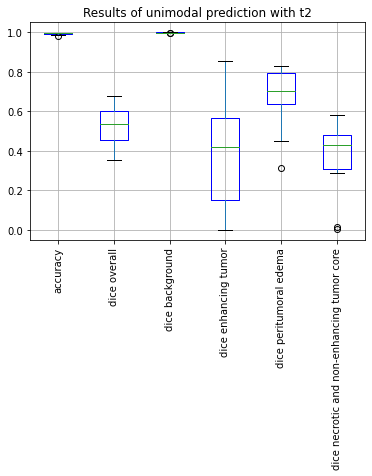

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
df.boxplot(rot=90,boxprops=dict(color='blue'))
plt.title("Results of unimodal prediction with t2")
plt.show()